In [3]:
import time

import requests
from pprint import pprint


In [4]:

API_KEY = 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'

url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
params = {
    "begin_date": "20220301",
    "end_date": "20220331",
    "sort": "best",
    "fq": 'section.name:("U.S." "World")',
    "api-key": API_KEY
}



In [5]:
def get_str_from_month (num):
    num_str = str(num)
    if len(str(num)) == 1:
        num_str = "0" + num_str
    return num_str

In [24]:
from calendar import monthrange
request_list = []
for x in range (1,13):
    _params = {
    "begin_date": f"2022{get_str_from_month(x)}01",
    "end_date": f"2022{get_str_from_month(x)}{monthrange(2022, x)[1]}",
    "sort": "best",
    "fq": 'section.name:("U.S." "World")',
    "api-key": API_KEY}
    request_list.append([_params,'2022',x])

In [25]:
print(request_list)

[[{'begin_date': '20220101', 'end_date': '20220131', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 1], [{'begin_date': '20220201', 'end_date': '20220228', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 2], [{'begin_date': '20220301', 'end_date': '20220331', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 3], [{'begin_date': '20220401', 'end_date': '20220430', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 4], [{'begin_date': '20220501', 'end_date': '20220531', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 5], [{'begin_date': '20220601', 'end_date': '20220630', 'sort': 'best', 'fq': 'section.name:("U.S." "World")', 'api-key': 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'}, '2022', 6

In [13]:
import time
def get_response_and_data(response_params):
    response = requests.get(url, params=response_params)
    time.sleep(1)
    data = response.json()
    time.sleep(1)
    return response, data



In [26]:
import requests
import sqlite3

def extract_titles_from_request(request_params, year, month, db_path="titles.db"):
    # Make API request
    response = requests.get(url, params=request_params)
    data = response.json()

    # Extract titles
    titles = []
    for article in data['response']['docs']:
        title = article['headline']['main']
        titles.append(title)

    # Connect to SQLite database (creates it if it doesn't exist)
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create table with year and month if it doesn't exist
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS article_titles (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            title TEXT NOT NULL,
            year INTEGER NOT NULL,
            month INTEGER NOT NULL
        )
    ''')

    # Insert titles with year and month into the table
    for title in titles:
        cursor.execute('INSERT INTO article_titles (title, year, month) VALUES (?, ?, ?)',
                       (title, year, month))

    # Commit and close
    conn.commit()
    conn.close()

    return titles


In [27]:
response = requests.get(url, params=request)
data = response.json()
data

{'status': 'OK',
 'copyright': 'Copyright (c) 2025 The New York Times Company. All Rights Reserved.',
 'response': {'docs': [{'abstract': '',
    'byline': {'original': 'By Maham Javaid'},
    'document_type': 'article',
    'headline': {'main': 'The U.N. has documented at least 3,924 Ukrainian civilian deaths in the war.',
     'kicker': '',
     'print_headline': ''},
    '_id': 'nyt://article/67585319-d0a5-5299-a45c-99f0a5f020fb',
    'keywords': [],
    'multimedia': {'caption': 'A gravedigger working at a site where 30 unidentified bodies were buried last week in Bilohorodka, near Kyiv.',
     'credit': 'Mauricio Lima for The New York Times',
     'default': {'url': 'https://static01.nyt.com/images/2022/06/29/world/29ukraine-briefing-UN-Casualties/merlin_208893402_3daac555-8b03-4730-9224-8dae46985d6b-articleLarge.jpg',
      'height': 400,
      'width': 600},
     'thumbnail': {'url': 'https://static01.nyt.com/images/2022/06/29/world/29ukraine-briefing-UN-Casualties/29ukraine-bri

In [22]:
extract_titles_from_request(request)

['The U.N. has documented at least 3,924 Ukrainian civilian deaths in the war.',
 'BA.4 and BA.5 will soon dominate across the Americas, a regional W.H.O. official says.',
 'A More Muscular NATO Emerges as West Confronts Russia and China',
 'Unilever Sells Ben & Jerry’s Business in Israel, Defusing Dispute',
 'Turkey’s critics, including Sweden’s Kurdish citizens, lash out over the NATO agreement.',
 'Putin wants to take most of Ukraine, but a quick breakthrough is unlikely, the top U.S. intelligence official says.',
 'Prince Charles to Stop Accepting Large Cash Donations for Charities',
 '20 Men Convicted in November 2015 Paris Terrorist Attack',
 'Americans Who Died at Bahamas Resort Were Poisoned by Carbon Monoxide',
 'E.U. Proposes Ban on Flavored Heated Tobacco Products']

In [31]:
titles_list = []
for request, year, month in request_list[5:6]:
    titles = extract_titles_from_request(request, year, month)
    titles_list.append(titles)


In [6]:
# Create an empty list to store titles
def display_request_info(data):
    titles = []

    # Loop through the articles and extract titles
    for article in data['response']['docs']:
        title = article['headline']['main']  # Get the main headline
        titles.append(title)  # Store the title in the array

        # Optionally, you can print other details if you like
        print(f"Title: {title}")
        print(f"Date: {article['pub_date']}")
        print(f"URL: {article['web_url']}")
        print(f"Section: {article.get('section_name')}")
        print(f"Word count: {article.get('word_count')}")
        print("-" * 50)

    # Now the 'titles' array holds all the titles from the articles
    print("Titles array:", titles)
    return titles


Title: Russian soldiers have accidentally shot down their own planes, a U.K. spy chief says.
Date: 2022-03-30T23:56:28Z
URL: https://www.nytimes.com/live/2022/03/30/world/ukraine-russia-war-news/russian-soldiers-have-shot-down-their-own-planes-the-uk-spy-chief-says
Section: World
Word count: 358
--------------------------------------------------
Title: Russia Steps Up Attacks Amid Reports of Rifts in Moscow
Date: 2022-03-30T23:17:37Z
URL: https://www.nytimes.com/2022/03/30/world/europe/ukraine-russia-war.html
Section: World
Word count: 1328
--------------------------------------------------
Title: The U.N. appoints a commission to investigate allegations of war crimes in Ukraine.
Date: 2022-03-30T22:27:12Z
URL: https://www.nytimes.com/live/2022/03/31/world/ukraine-russia-war-news/the-un-appoints-a-commission-to-investigate-allegations-of-war-crimes-in-ukraine
Section: World
Word count: 632
--------------------------------------------------
Title: President Dissolves Tunisia’s Parliamen

In [7]:
title = article['headline']['main']
title

'‘Like living in a horror movie’: A first-hand dispatch from a town on Ukraine’s front line.'

In [51]:
from transformers import pipeline


C:\Users\zecab\Repositories\Sentiment_Analysis_NYT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# Initialize sentiment-analysis pipeline using RoBERTa

sentiment_pipeline = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

Device set to use cpu


In [38]:
import sqlite3
import pandas as pd
def fetch_titles_df(db_path="titles.db"):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)

    # Use pandas to execute SQL and load into DataFrame
    df = pd.read_sql_query('SELECT * FROM article_titles', conn)

    # Close the connection
    conn.close()

    return df


In [40]:
titles_df = fetch_titles_df(db_path="titles.db")

In [48]:
titles_df[(titles_df['year'] == 2022) & (titles_df['month'] == 1)]['title']


0    The Hard-Line Russian Advisers Who Have Putin’...
1    Obscure but Crucial Commodity Fuels Geopolitic...
2    Britain Toughens Stance on Russia, as Russia P...
3    England extends vaccines to vulnerable childre...
4    Covid-era controls may outlast the virus in Ch...
5    U.S. Allies Retake Control of Prison in Syria,...
6    Living by the Code: In China, Covid-Era Contro...
7    North Korea’s Latest Missile Test Appears to B...
8    New York coronavirus cases fell by 50 percent ...
9    For those with underlying conditions, an Omicr...
Name: title, dtype: object

In [10]:
result = sentiment_pipeline(titles)
print(result)

[{'label': 'NEGATIVE', 'score': 0.9926397800445557}, {'label': 'NEGATIVE', 'score': 0.8799412250518799}, {'label': 'NEGATIVE', 'score': 0.8092053532600403}, {'label': 'NEGATIVE', 'score': 0.996826171875}, {'label': 'NEGATIVE', 'score': 0.9983242154121399}, {'label': 'NEGATIVE', 'score': 0.9454824924468994}, {'label': 'NEGATIVE', 'score': 0.961261510848999}, {'label': 'NEGATIVE', 'score': 0.9969139099121094}, {'label': 'NEGATIVE', 'score': 0.9986878037452698}, {'label': 'NEGATIVE', 'score': 0.7420502305030823}]


In [58]:
month_titles.shape

(10,)

In [62]:
month_titles = ['bad things happen']

In [68]:
result = sentiment_pipeline(titles_list)
print(result)

[{'label': 'POSITIVE', 'score': 0.9702621698379517}, {'label': 'NEGATIVE', 'score': 0.9908248782157898}, {'label': 'NEGATIVE', 'score': 0.990691602230072}, {'label': 'POSITIVE', 'score': 0.9894587993621826}, {'label': 'POSITIVE', 'score': 0.9904552102088928}, {'label': 'NEGATIVE', 'score': 0.9408500790596008}, {'label': 'POSITIVE', 'score': 0.5470793843269348}, {'label': 'POSITIVE', 'score': 0.9963990449905396}, {'label': 'NEGATIVE', 'score': 0.9990426898002625}, {'label': 'NEGATIVE', 'score': 0.9870733022689819}]


In [66]:
list(titles_df[(titles_df['year'] == 2022) & (titles_df['month'] == 1)]['title'])

['The Hard-Line Russian Advisers Who Have Putin’s Ear',
 'Obscure but Crucial Commodity Fuels Geopolitical Tussle in Eastern Europe',
 'Britain Toughens Stance on Russia, as Russia Presses NATO for Assurances',
 'England extends vaccines to vulnerable children ages 5 to 11.',
 'Covid-era controls may outlast the virus in China.',
 'U.S. Allies Retake Control of Prison in Syria, Subduing ISIS Fighters',
 'Living by the Code: In China, Covid-Era Controls May Outlast the Virus',
 'North Korea’s Latest Missile Test Appears to Be Its Boldest in Years',
 'New York coronavirus cases fell by 50 percent in the past week.',
 'For those with underlying conditions, an Omicron infection can be anything but mild.']

In [76]:
titles_df

,id,title,year,month
0,1,The Hard-Line Russian Advisers Who Have Putin’...,2022,1
1,2,Obscure but Crucial Commodity Fuels Geopolitic...,2022,1
2,3,"Britain Toughens Stance on Russia, as Russia P...",2022,1
3,4,England extends vaccines to vulnerable childre...,2022,1
4,5,Covid-era controls may outlast the virus in Ch...,2022,1
...,...,...,...,...
115,116,"Putin wants to take most of Ukraine, but a qui...",2022,6
116,117,Prince Charles to Stop Accepting Large Cash Do...,2022,6
117,118,20 Men Convicted in November 2015 Paris Terror...,2022,6
118,119,Americans Who Died at Bahamas Resort Were Pois...,2022,6


In [79]:
monthly_sentiment_averages = {}

for month in range (1,13):
    titles_list = list(titles_df[(titles_df['year'] == 2022) & (titles_df['month'] == month)]['title'])
    result = sentiment_pipeline(titles_list)
    labels = [res['label'] for res in result]
    scores = [res['score'] if res['label'] == 'POSITIVE' else -res['score'] for res in result]
    avg_score = sum(scores) / len(scores)
    monthly_sentiment_averages[month] = avg_score



In [80]:
monthly_sentiment_averages

{1: -0.04148279428482056,
 2: -0.012457376718521119,
 3: -0.9321332693099975,
 4: -0.6119625926017761,
 5: -0.243185418844223,
 6: -0.5426965653896332,
 7: -0.7802978217601776,
 8: -0.20738871693611144,
 9: -0.0005969583988189697,
 10: -0.207761013507843,
 11: -0.3725851058959961,
 12: -0.4373254895210266}

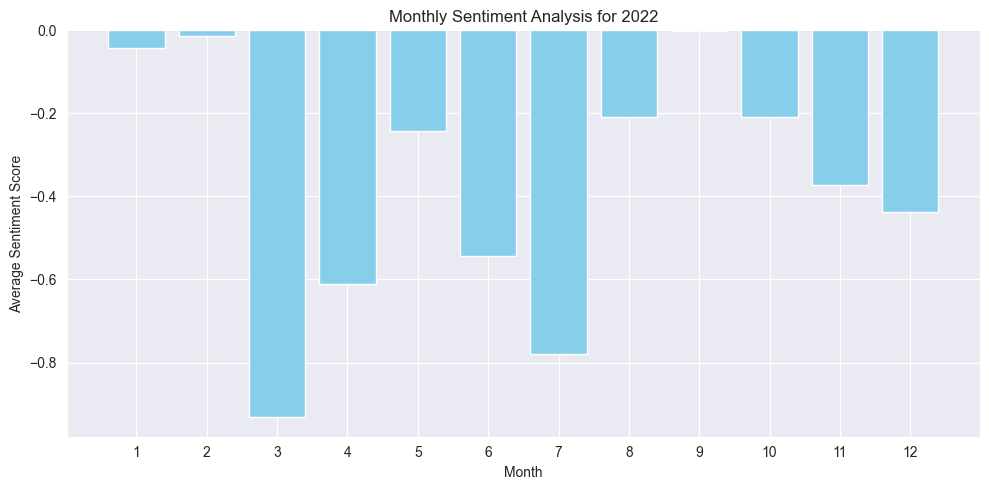

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract months and scores
months = list(monthly_sentiment_averages.keys())
scores = list(monthly_sentiment_averages.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(months, scores, color='skyblue')
plt.axhline(0, color='gray', linestyle='--')  # Neutral line
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.title('Monthly Sentiment Analysis for 2022')
plt.tight_layout()
plt.show()

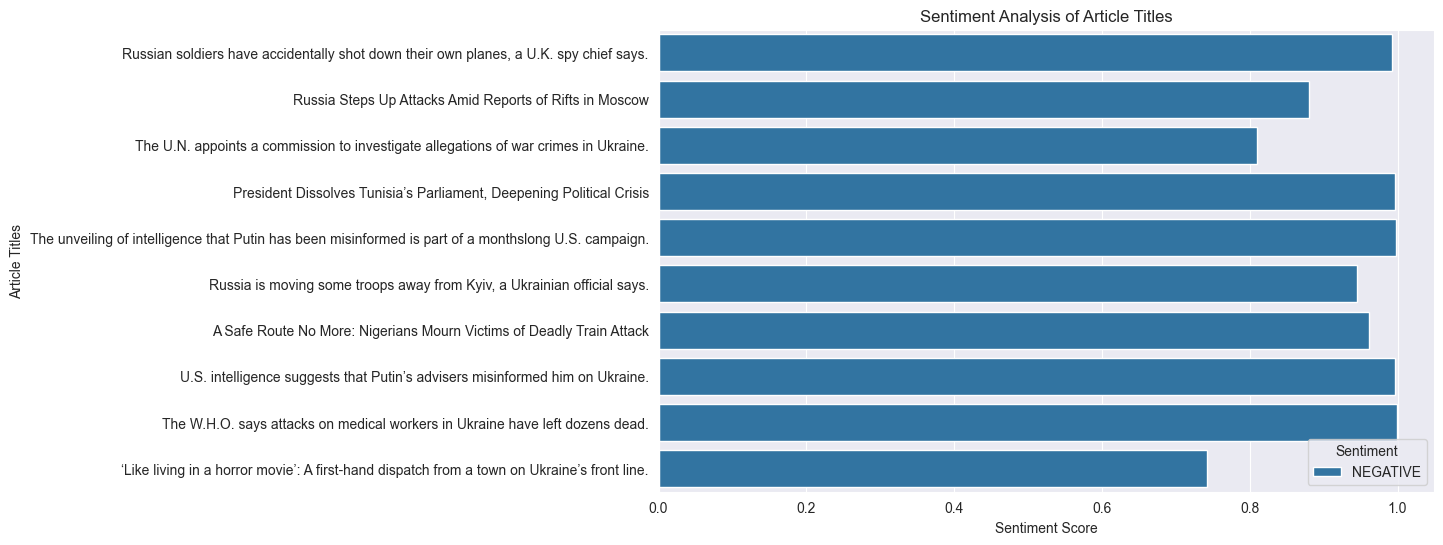

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# Extracting sentiment labels and scores from the result
labels = [res['label'] for res in result]
scores = [res['score'] for res in result]

# Create a DataFrame for easy plotting
df = pd.DataFrame({
    'Title': titles,  # The titles of the articles
    'Sentiment': labels,  # Sentiment labels (Positive, Negative, Neutral)
    'Sentiment Score': scores  # Sentiment scores
})

# Set up the Seaborn plot
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Sentiment Score', y='Title', data=df, hue='Sentiment', dodge=False)

# Customize the plot
plt.title('Sentiment Analysis of Article Titles')
plt.xlabel('Sentiment Score')
plt.ylabel('Article Titles')

# Show the plot
plt.show()


Similarity Matrix Shape: torch.Size([10, 10])


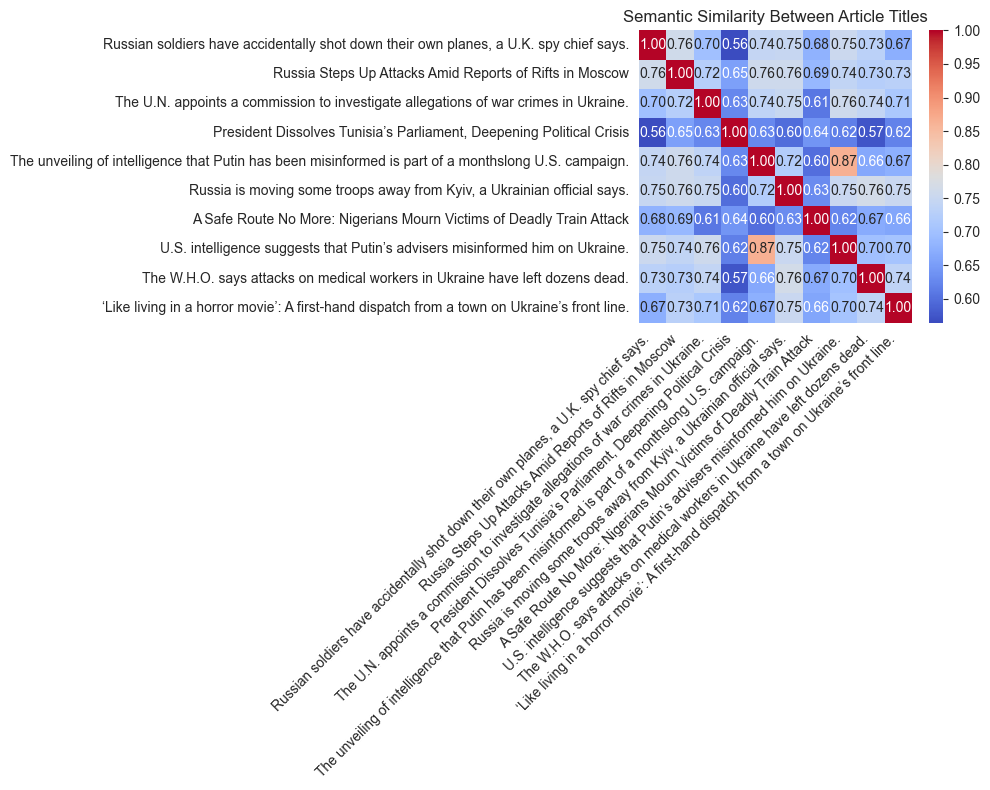

In [12]:
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

# List of titles


# Load model
model = SentenceTransformer("jinaai/jina-embeddings-v2-base-en", trust_remote_code=True)

# Encode titles
embeddings = model.encode(titles)

# Calculate similarity matrix
similarities = model.similarity(embeddings, embeddings)

# Print similarity matrix shape
print("Similarity Matrix Shape:", similarities.shape)

# Optional: Display similarity matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarities, xticklabels=titles, yticklabels=titles, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Semantic Similarity Between Article Titles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [13]:
title_embeddings = {title: embedding for title, embedding in zip(titles, embeddings)}

# Print each title and the first few numbers from its embedding
for title, embedding in title_embeddings.items():
    print(f"Title: {title}")
    print(f"Embedding (first 5 dims): {embedding[:5]}")
    print("-" * 50)

Title: Russian soldiers have accidentally shot down their own planes, a U.K. spy chief says.
Embedding (first 5 dims): [-0.01376439 -0.0073463   0.04595992 -0.01744858 -0.00292111]
--------------------------------------------------
Title: Russia Steps Up Attacks Amid Reports of Rifts in Moscow
Embedding (first 5 dims): [-0.00939452 -0.0303266   0.02204572  0.0098193  -0.00650735]
--------------------------------------------------
Title: The U.N. appoints a commission to investigate allegations of war crimes in Ukraine.
Embedding (first 5 dims): [-0.03540333 -0.01485641  0.03710288  0.00030505 -0.04909159]
--------------------------------------------------
Title: President Dissolves Tunisia’s Parliament, Deepening Political Crisis
Embedding (first 5 dims): [-0.03385242 -0.04037231  0.01586283  0.02267834 -0.05558509]
--------------------------------------------------
Title: The unveiling of intelligence that Putin has been misinformed is part of a monthslong U.S. campaign.
Embedding (fi